# Progetto Tesi Calciatori Under 21

## Importazione librerie

In [2]:
import requests
from bs4 import BeautifulSoup as soup
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
import time
from request_get import *
from datetime import datetime
from dateutil import relativedelta
import statsmodels.api as sm
from scipy.stats import f_oneway,kstest
from scipy import stats
import numpy as np
import ruptures as rpt
import Rbeast as rb
import pymannkendall as mk

## Importazione dataset

In [8]:
# le funzioni che seguono servono a prendere i dati da fbref e transfermarkt e salvarli in un file xlsx (definite nel file request_get.py)
#get_fbref()
#get_transfermarkt(1958,10)

In [3]:
uefa_ranking=get_uefa_ranking()
uefa_ranking.head()

,Uefa_Ranking
1969,7.836865
1970,5.514087
1971,8.993416
1972,7.912378
1973,3.796904


## Estrazione minuti di gioco

In [138]:
# Calcola i minuti giocati dai giocatori under 21 per ogni anno, stabilendo come under 21 i giocatori nati dopo il 1 Agosto 
mesi = {
    "gen": 1, "feb": 2, "mar": 3, "apr": 4, "mag": 5, "giu": 6, "lug": 7, "ago": 8, "set": 9, "ott": 10, "nov": 11, "dic": 12
}
mins_played=pd.DataFrame(columns=["Minuti giocati under21","Minuti giocati Italiani","Minuti giocati Stranieri","Minuti giocati Oriundi"])
current_year = 2022

# Define the number of years you want to subtract
year_to_subtract = 56

for i in range(year_to_subtract):
    # Calculate the year to use in the URL
    year_url = f"{current_year - i}-{current_year + 1 - i}"
    
    
    #players_fbref=pd.read_excel(f"fbref\SerieA{year_url}-Under21.xlsx")
    players_tm=pd.read_excel(f"transfermarkt\SerieA{year_url}-Under21.xlsx")
    for j in range(len(players_tm)):
        parti = players_tm.loc[j,"Nato"].split('/')
        giorno_nasc = int(parti[0])
        mese_nasc = mesi[parti[1].lower()]  # Mappa il mese in minuscolo
        anno_nasc = int(parti[2])
        data_nasc = datetime(anno_nasc, mese_nasc, giorno_nasc)
        players_tm.loc[j,"Data di nascita"]=data_nasc
        data_inizio=datetime(current_year-i, 8, 1)
        anni=relativedelta.relativedelta(data_inizio, data_nasc).years
        players_tm.loc[j,"Anni"]=anni
    under=players_tm[players_tm["Anni"]<21]
    under_italia=under[under["Nazione"]=="Italia"]
    #under_stranieri = under[~under["Nazione"].str.contains(r'\bItalia\b', case=False, na=False)]
    under_stranieri= under[~under["Nazione"].str.contains(r'\b^Italia$\b|^Italia/\b', case=False, na=False)]
    under_oriundi = under[under["Nazione"].str.contains(r'^Italia/\b', case=False, na=False)]
    #under_stranieri=under[under["Nazione"]!="Italia"]
    mins_played.loc[year_url,"Minuti giocati Italiani"]=under_italia["Minuti giocati"].sum()
    mins_played.loc[year_url,"Minuti giocati under21"]=under["Minuti giocati"].sum()
    mins_played.loc[year_url,"Minuti giocati Stranieri"]=under_stranieri["Minuti giocati"].sum()
    mins_played.loc[year_url,"Minuti giocati Oriundi"]=under_oriundi["Minuti giocati"].sum()
    

    #mins_played.loc[year_url,"Minuti giocati FB"]=players_fbref["Minuti giocati"].sum()
    #mins_played.loc[year_url,"Minuti giocati TM"]=players_tm["Minuti giocati"].sum()
    #mins_played.loc[year_url,"TM - FB"]=mins_played.loc[year_url,"Minuti giocati FIX"]-mins_played.loc[year_url,"Minuti giocati FB"]




In [258]:
mins_played=mins_played.iloc[::-1]


In [60]:
mins_played.head()

,Minuti giocati under21,Minuti giocati Italiani,Minuti giocati Stranieri,Minuti giocati Oriundi
2022-2023,45572,18087,22674,4811
2021-2022,43062,13170,25820,4072
2020-2021,44079,11647,30255,2177
2019-2020,46677,18810,27093,774
2018-2019,58669,17383,39722,1564


### Normalizzazione minuti di gioco

In [139]:
#normalize Minuti giocati to total minutes played in the league and create another column(from 2022-2023 to 2004-2005 divided for 3420 minutes, from 2003-2004 to 1988-1989 divided for 3060 minutes and from 1987-1988 to 1968-1969 divided for 2700 minutes)
#mins_played["Minuti giocati normalizzati Fbref"]=0
#inverte l'ordine delle righe del dataframe con in testa 1968 e coda 2022
mins_played=mins_played.iloc[::-1]

#1967, cioè -56
mins_played[0:21]=mins_played[0:21]/(90*11*30*20)*100
mins_played[21:37]=mins_played[21:37]/(90*11*34*20)*100
mins_played[37:]=mins_played[37:]/(90*11*38*20)*100


"""
#1951, cioè -72
mins_played[0:16]=mins_played[0:16]/(90*11*34*20)*100
mins_played[16:37]=mins_played[16:37]/(90*11*30*20)*100
mins_played[37:53]=mins_played[37:53]/(90*11*34*20)*100
mins_played[53:]=mins_played[53:]/(90*11*38*20)*100 """

"""
mins_played["Minuti giocati totali"]=0
mins_played["Minuti giocati totali"][0:19]=594000
mins_played["Minuti giocati totali"][19:35]=673200
mins_played["Minuti giocati totali"][35:]=752400"""

mins_played["Minuti giocati under21"]=mins_played["Minuti giocati under21"].astype(float)
mins_played["Minuti giocati Italiani"]=mins_played["Minuti giocati Italiani"].astype(float)
mins_played["Minuti giocati Stranieri"]=mins_played["Minuti giocati Stranieri"].astype(float)
mins_played["Minuti giocati Oriundi"]=mins_played["Minuti giocati Oriundi"].astype(float)


In [264]:
mins_played.head()

,Minuti giocati under21,Minuti giocati Italiani,Minuti giocati Stranieri,Minuti giocati Oriundi
1967-1968,5.987542,5.987542,0.0,0.000000
1968-1969,4.841582,4.826431,0.0,0.015152
1969-1970,6.181818,6.181818,0.0,0.000000
1970-1971,5.095118,5.095118,0.0,0.000000
1971-1972,6.451515,6.443939,0.0,0.007576


In [11]:
mins_played.tail()

,Minuti giocati FIX,Minuti giocati Italiani,Minuti giocati Stranieri,Minuti giocati normalizzati Italiani,Minuti giocati normalizzati Stranieri,Minuti giocati normalizzati FIX,Minuti giocati totali
2018-2019,58666.0,18945,39721,2.517943,5.27924,7.797182,752400
2019-2020,46669.0,19584,27085,2.602871,3.599814,6.202685,752400
2020-2021,44079.0,13824,30255,1.837321,4.021132,5.858453,752400
2021-2022,43060.0,17242,25818,2.291600,3.431419,5.723020,752400
2022-2023,45572.0,22898,22674,3.043328,3.013557,6.056885,752400


In [24]:
#!!!!!!join the dataframe mins_played with uefa_ranking and italy_ranking!!!!!!!!

#mins_played=mins_played.join(uefa_ranking,how='outer')
#mins_played=mins_played.join(italy_ranking,how='outer')

In [133]:
mins_played.tail()

,Minuti giocati under21,Minuti giocati Italiani,Minuti giocati Stranieri,Minuti giocati Oriundi,Minuti giocati totali,Uefa_Ranking,RK,Points
2018,7.797581,2.310340,5.279373,0.207868,752400,7.138945,19.0,1.012055
2019,6.203748,2.500000,3.600877,0.102871,752400,8.502446,15.0,1.036934
2020,5.858453,1.547980,4.021132,0.289341,752400,9.234215,12.0,1.046726
2021,5.723285,1.750399,3.431685,0.541201,752400,7.262794,4.0,1.121325
2022,6.056885,2.403907,3.013557,0.639421,752400,11.187226,6.0,1.099593


## Bayesian changepoint detection con Rbeast

### Analisi changepoint under-21


#####################################################################
#                      Seasonal  Changepoints                       #
#####################################################################
 No seasonal/periodic component present (i.e., season='none')


#####################################################################
#                      Trend  Changepoints                          #
#####################################################################
.-------------------------------------------------------------------.
| Ascii plot of probability distribution for number of chgpts (ncp) |
.-------------------------------------------------------------------.
|Pr(ncp = 0 )=0.011|**                                              |
|Pr(ncp = 1 )=0.030|*****                                           |
|Pr(ncp = 2 )=0.169|***********************                         |
|Pr(ncp = 3 )=0.350|*********************************************** |
|Pr(ncp = 4 )=0.270|*****

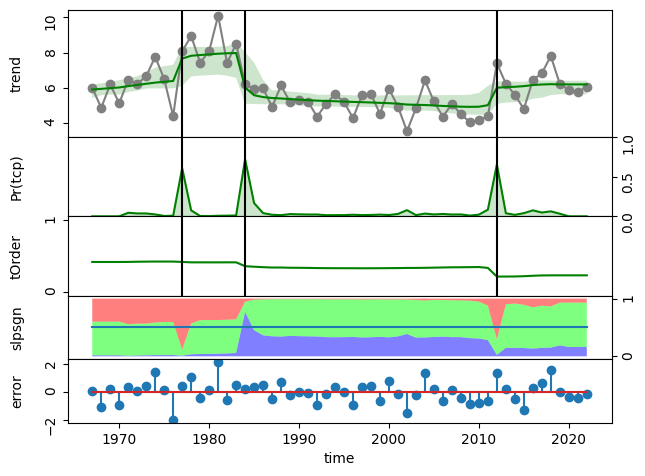

In [144]:
import numpy as np
o=rb.beast(mins_played['Minuti giocati under21'], start=1967, deltat=1,period="1.0 year",mcmc_seed=1,print_options = False,print_progress=False)
rb.plot(o,title='')
rb.print(o)


In [142]:
#mins_played['Minuti giocati under21'][9]=5.4
mins_played['Minuti giocati under21'][15]=7.4

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\Rbeast\plotbeast.py:294: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


#####################################################################
#                      Seasonal  Changepoints                       #
#####################################################################
 No seasonal/periodic component present (i.e., season='none')


#####################################################################
#                      Trend  Changepoints                          #
#####################################################################
.-------------------------------------------------------------------.
| Ascii plot of probability distribution for number of chgpts (ncp) |
.-------------------------------------------------------------------.
|Pr(ncp = 0 )=0.015|**                                              |
|Pr(ncp = 1 )=0.430|*********************************************** |
|Pr(ncp = 2 )=0.370|*****************************************       |
|Pr(ncp = 3 )=0.150|*****************                               |
|Pr(ncp = 4 )=0.033|****  

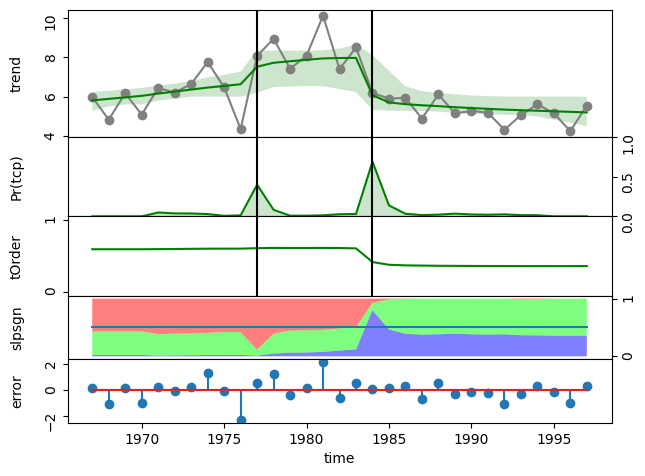

In [143]:
import numpy as np
o=rb.beast(mins_played['Minuti giocati under21'][0:31], start=1967, deltat=1,period="1.0 year",mcmc_seed=1,print_options = False,print_progress=False)
rb.plot(o,title='')
rb.print(o)

In [147]:
mins_played['Minuti giocati under21'][21:]

1988-1989    6.118093
1989-1990    5.161616
1990-1991    5.281640
1991-1992    5.199049
1992-1993    4.331105
1993-1994    5.068627
1994-1995    5.617350
1995-1996    5.172906
1996-1997    4.260992
1997-1998    5.555110
1998-1999    5.621064
1999-2000    4.505348
2000-2001    5.929293
2001-2002    4.913844
2002-2003    3.509804
2003-2004    4.816993
2004-2005    6.406433
2005-2006    5.206007
2006-2007    4.334264
2007-2008    5.075492
2008-2009    4.469032
2009-2010    4.025651
2010-2011    4.143674
2011-2012    4.362440
2012-2013    7.380383
2013-2014    6.223285
2014-2015    5.579612
2015-2016    4.778841
2016-2017    6.425837
2017-2018    6.818979
2018-2019    7.797581
2019-2020    6.203748
2020-2021    5.858453
2021-2022    5.723285
2022-2023    6.056885
Name: Minuti giocati under21, dtype: float64


#####################################################################
#                      Seasonal  Changepoints                       #
#####################################################################
 No seasonal/periodic component present (i.e., season='none')


#####################################################################
#                      Trend  Changepoints                          #
#####################################################################
.-------------------------------------------------------------------.
| Ascii plot of probability distribution for number of chgpts (ncp) |
.-------------------------------------------------------------------.
|Pr(ncp = 0 )=0.147|*************                                   |
|Pr(ncp = 1 )=0.558|*********************************************** |
|Pr(ncp = 2 )=0.230|********************                            |
|Pr(ncp = 3 )=0.054|*****                                           |
|Pr(ncp = 4 )=0.010|*    

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\Rbeast\plotbeast.py:294: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


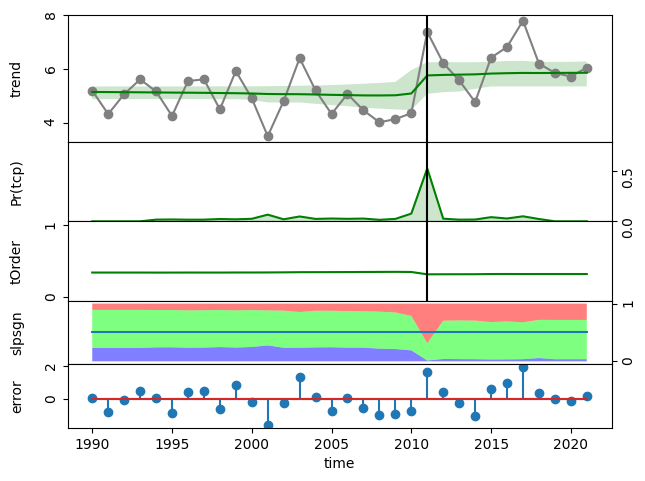

In [148]:
#Trend and changepoint in the number of minutes played by under-21 players from 1990
import Rbeast as rb
import numpy as np
o=rb.beast(mins_played['Minuti giocati under21'][24:], start=1990, deltat=1,period="1.0 year",print_options=False,print_progress=False)
rb.plot(o,title='')
rb.print(o)



### Analisi changepoint italiani under-21

In [152]:
mins_played['Minuti giocati Italiani'][15]=7.37


#####################################################################
#                      Seasonal  Changepoints                       #
#####################################################################
 No seasonal/periodic component present (i.e., season='none')


#####################################################################
#                      Trend  Changepoints                          #
#####################################################################
.-------------------------------------------------------------------.
| Ascii plot of probability distribution for number of chgpts (ncp) |
.-------------------------------------------------------------------.
|Pr(ncp = 0 )=0.000|*                                               |
|Pr(ncp = 1 )=0.020|**                                              |
|Pr(ncp = 2 )=0.621|*********************************************** |
|Pr(ncp = 3 )=0.272|*********************                           |
|Pr(ncp = 4 )=0.069|*****

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\Rbeast\plotbeast.py:294: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


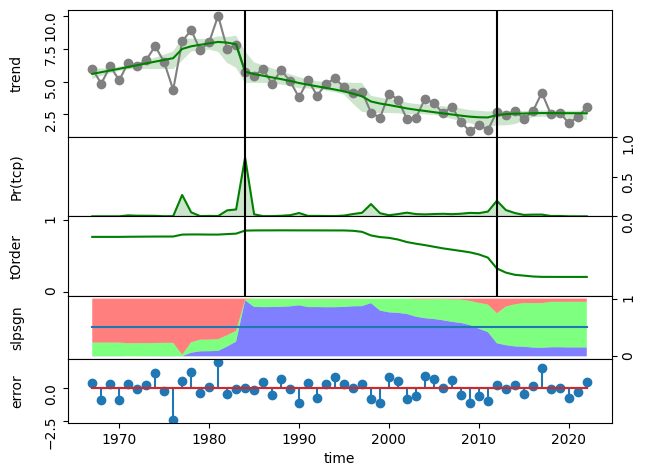

In [153]:

import Rbeast as rb
import numpy as np
o=rb.beast((mins_played['Minuti giocati Italiani'] +mins_played['Minuti giocati Oriundi'] ), start=1967, deltat=1,period="1.0 year",print_options = False,print_progress=False)
rb.plot(o,title='')
rb.print(o)



#####################################################################
#                      Seasonal  Changepoints                       #
#####################################################################
 No seasonal/periodic component present (i.e., season='none')


#####################################################################
#                      Trend  Changepoints                          #
#####################################################################
.-------------------------------------------------------------------.
| Ascii plot of probability distribution for number of chgpts (ncp) |
.-------------------------------------------------------------------.
|Pr(ncp = 0 )=0.000|*                                               |
|Pr(ncp = 1 )=0.000|*                                               |
|Pr(ncp = 2 )=0.000|*                                               |
|Pr(ncp = 3 )=0.752|*********************************************** |
|Pr(ncp = 4 )=0.230|*****

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\Rbeast\plotbeast.py:294: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


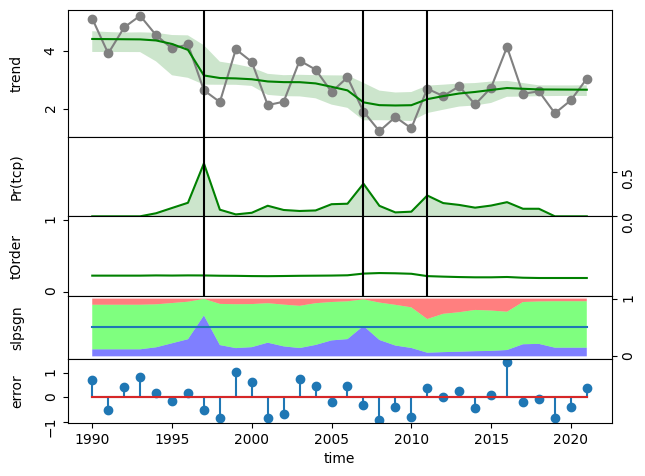

In [154]:
import Rbeast as rb
import numpy as np
o=rb.beast((mins_played['Minuti giocati Italiani'][24:]+mins_played['Minuti giocati Oriundi'][24:]), start=1990, deltat=1,period="1.0 year",tcp_minmax = [3,5],ncp_minmax = [2,4],torder_minmax= [0, 1],norder_minmax = [0, 1],trend_minmax = [0, 1],print_options=False,print_progress=False)
rb.plot(o,title='')
rb.print(o)


## Bayesian changepoint detection con Ruptures

In [ ]:
#modify the index of mins_played and get only the first part(examples: 2022-2023 becomes 2022, 2021-2022 becomes 2021)
mins_played.index=mins_played.index.str[:4].astype(int)
#convert the index of mins_played to DateTime
mins_played.index=pd.to_datetime(mins_played.index, format='%Y')

In [122]:
impressions = mins_played["Minuti giocati under21"][15:].values.reshape(-1, 1)

impressions_first_up_trend = mins_played["Minuti giocati under21"][15:36].values.reshape(-1, 1)

In [67]:
#create a 2 shape array with index and values of mins_played
impressions = mins_played["Minuti giocati Italiani"][21:].values.reshape(-1, 1) + mins_played["Minuti giocati Oriundi"][21:].values.reshape(-1, 1)
index = mins_played["Minuti giocati under21"][21:].index.year.values.reshape(-1, 1)
impressions.shape, index.shape

((33, 1), (33, 1))

In [70]:
#create a 2 shape array with index and values of mins_played
impressions = mins_played["Minuti giocati under21"].values.reshape(-1, 1)
index = mins_played["Minuti giocati under21"].index.year.values.reshape(-1, 1)
impressions.shape, index.shape

#create a 2 shape array with index and impressions





((54, 1), (54, 1))

In [70]:
mins_played.head()

,Minuti giocati under21,Minuti giocati Italiani,Minuti giocati Stranieri,Minuti giocati Oriundi
1967-1968,5.987542,5.987542,0.0,0.000000
1968-1969,4.841582,4.826431,0.0,0.015152
1969-1970,6.181818,6.181818,0.0,0.000000
1970-1971,5.095118,5.095118,0.0,0.000000
1971-1972,6.451515,6.443939,0.0,0.007576


Punti di rottura trovati: [1973, 1982, 1989]


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

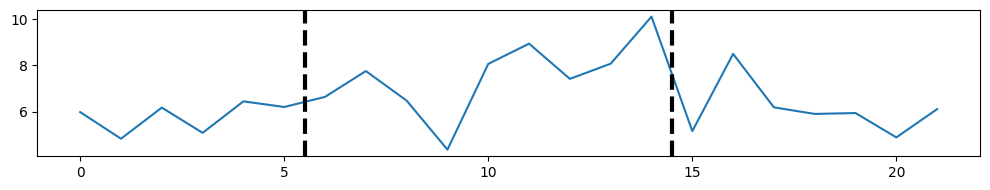

In [86]:
# Crea un punto di rottura con il modello "l1" (changepoint detection basato sulla somma delle differenze)
model = "l2"
impressions_first_up_trend = mins_played["Minuti giocati under21"][0:22].values.reshape(-1, 1)

# Esegui il rilevamento dei cambiamenti senza specificare il numero di punti di rottura
algo = rpt.Dynp(model=model, min_size=3,jump=3).fit(impressions_first_up_trend)
result = algo.predict(n_bkps=2)

# Stampa i punti di rottura trovati
print("Punti di rottura trovati:", [x+1967 for x in result])

# Puoi visualizzare i punti di rottura sul grafico
rpt.display(impressions_first_up_trend,[], result)

Punti di rottura trovati: [2011, 2023]


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

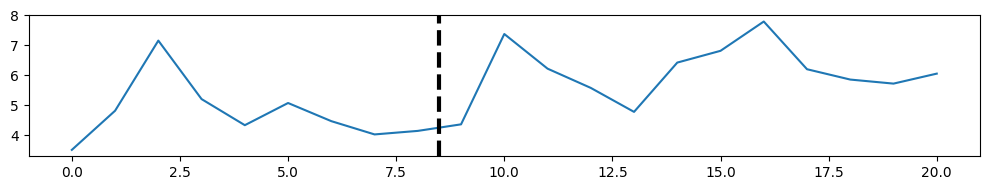

In [127]:
# Crea un punto di rottura con il modello "l1" (changepoint detection basato sulla somma delle differenze)
model = "l2"
impressions_final_trend = mins_played["Minuti giocati under21"][50:].values.reshape(-1, 1)
# Esegui il rilevamento dei cambiamenti senza specificare il numero di punti di rottura
algo = rpt.Dynp(model=model, min_size=1,jump=3).fit(impressions_final_trend)
result = algo.predict(n_bkps=1)

# Stampa i punti di rottura trovati
print("Punti di rottura trovati:", [x+2002 for x in result])

# Puoi visualizzare i punti di rottura sul grafico
rpt.display(impressions_final_trend,[], result)

Punti di rottura trovati: [1973, 1985, 2012, 2023]
Punti di rottura trovati: [6, 18, 45]


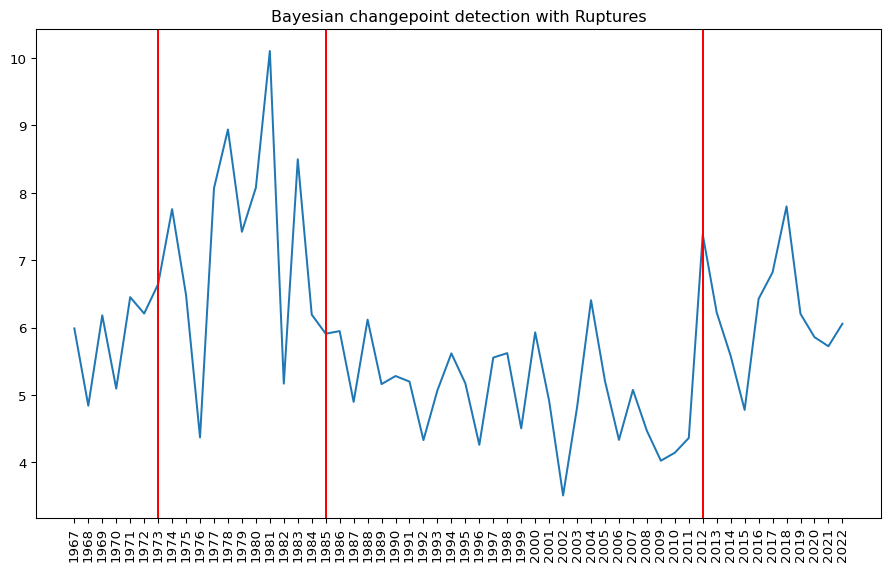

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(900/96, 560/96), dpi=96)

# Crea un punto di rottura con il modello "l1" (changepoint detection basato sulla somma delle differenze)
model = "l2"
impressions = mins_played["Minuti giocati under21"].values.reshape(-1, 1)

# Esegui il rilevamento dei cambiamenti senza specificare il numero di punti di rottura
algo = rpt.Dynp(model=model, min_size=3,jump=3).fit(impressions)
result = algo.predict(n_bkps=3)

# Stampa i punti di rottura trovati
print("Punti di rottura trovati:", [x+1967 for x in result])

# Puoi visualizzare i punti di rottura sul grafico
#rpt.display(impressions,[], result)
ax.plot(impressions)
for bkp in result[0:-1]:
    ax.axvline(x=bkp, color='r', )
ax.set_title("Bayesian changepoint detection with Ruptures")
fig.tight_layout()
#change the x ticks to be the index of mins_played
#crea una lista da 0 a 54
a=list(range(0,56))
b=list(range(1967,2023))
ax.set_xticks(a,b)
#ruota i tick di 90 gradi
plt.xticks(rotation=90)
print("Punti di rottura trovati:", result[0:-1])
plt.show()


Punti di rottura trovati: [10, 17, 45, 56]


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

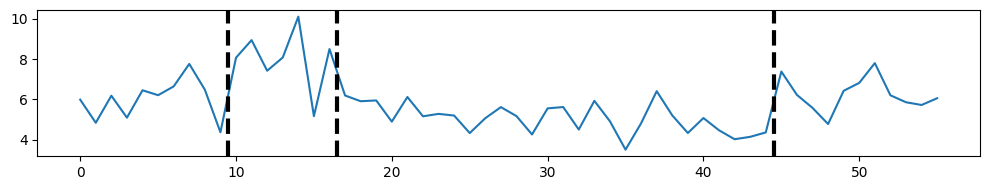

In [132]:
# Crea un punto di rottura con il modello "l1" (changepoint detection basato sulla somma delle differenze)
model = "l2"
impressions = mins_played["Minuti giocati under21"].values.reshape(-1, 1)

penalty=2*np.log(len(impressions))*np.std(impressions)**2
print
# Esegui il rilevamento dei cambiamenti senza specificare il numero di punti di rottura
algo = rpt.Pelt(model=model,jump=1).fit(impressions)
result = algo.predict(pen=10)

# Stampa i punti di rottura trovati
print("Punti di rottura trovati:", result)

# Puoi visualizzare i punti di rottura sul grafico
rpt.display(impressions,[], result)

Punti di rottura trovati: [10, 17, 45, 56]


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

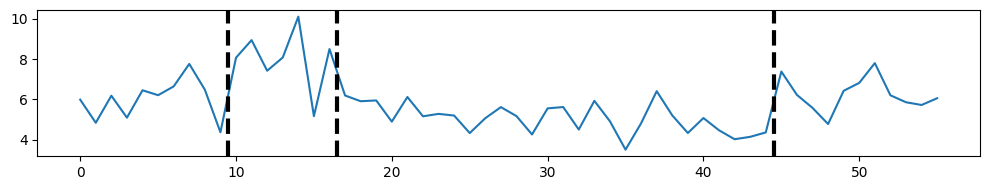

In [112]:
# Crea un punto di rottura con il modello "l1" (changepoint detection basato sulla somma delle differenze)
model = "l1"

# Esegui il rilevamento dei cambiamenti senza specificare il numero di punti di rottura
algo = rpt.Dynp(model=model, min_size=1,jump=1).fit(impressions)
result = algo.predict(n_bkps=3)

# Stampa i punti di rottura trovati
print("Punti di rottura trovati:", result)

# Puoi visualizzare i punti di rottura sul grafico
rpt.display(impressions,[], result)

Punti di rottura trovati: [1977, 1985, 2011, 2023]


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

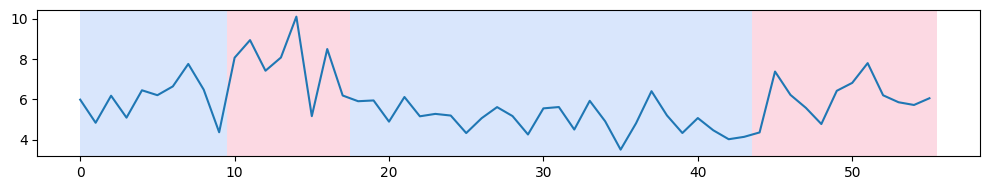

In [110]:
algo = rpt.BottomUp(model="l2",jump=2)
algo.fit(impressions)
result = algo.predict(pen=7)
#print result array and array of the number of points of rupture


print("Punti di rottura trovati:", [x+1967 for x in result])
# show results
rpt.display(impressions, result)

Punti di rottura trovati: [1977, 1987, 2012, 2023]


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

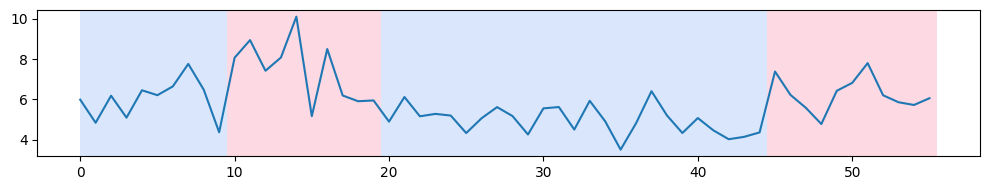

In [106]:
algo = rpt.Binseg(model="l2")
algo.fit(impressions)
result = algo.predict(n_bkps=3)
#print result array and array of the number of points of rupture
a=[5, 20, 45, 56]
#add 2000 to the array
b=[x+2000 for x in a]


print("Punti di rottura trovati:", [x+1967 for x in result])
# show results
rpt.display(impressions, result)


Punti di rottura trovati: [10, 15, 20, 45, 56]


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

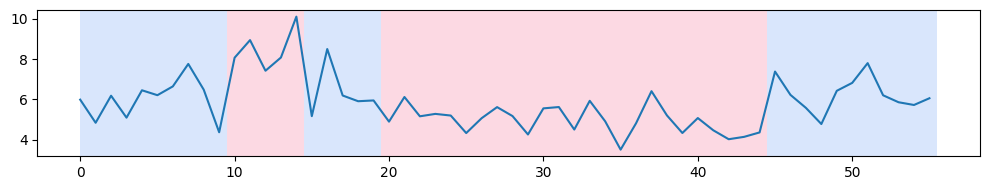

In [105]:
algo = rpt.Binseg(model="l1",min_size=1)
algo.fit(impressions)
result = algo.predict(n_bkps=4)
print("Punti di rottura trovati:", result)
# show results
rpt.display(impressions, result)


Punti di rottura trovati: []


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

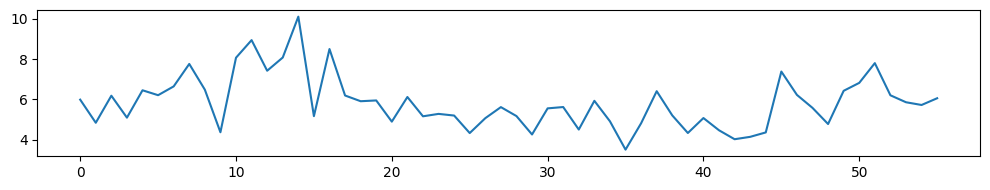

In [104]:
import ruptures as rpt

algo = rpt.Window(model="l2",width=10, min_size=1,jump=2)
algo.fit(impressions)
result = algo.predict(pen=2)
print("Punti di rottura trovati:", result[0:-1])
rpt.display(impressions, [], result,computed_chg_pts_color="red",computed_chg_pts_linestyle="-")
#set the x ticks to be the index of mins_played


Punti di rottura trovati: [8, 15, 43]


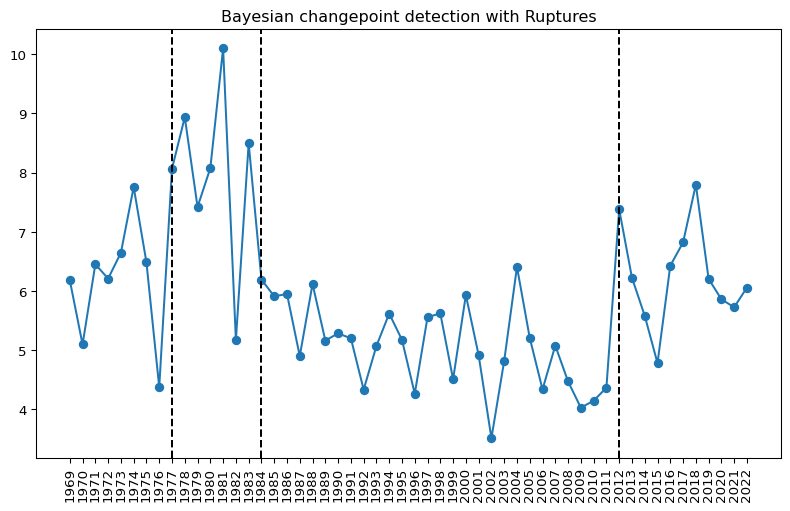

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(800/96, 500/96), dpi=96)

kernel = 'linear'
algo = rpt.KernelCPD(kernel=kernel, min_size=6)
algo.fit(impressions)
result = algo.predict(n_bkps=3)
ax.plot(impressions,marker='o')
for bkp in result[0:-1]:
    ax.axvline(x=bkp, color='k', linestyle='--')
ax.set_title("Bayesian changepoint detection with Ruptures")
fig.tight_layout()
#change the x ticks to be the index of mins_played
#crea una lista da 0 a 54
a=list(range(0,54))
b=list(range(1969,2023))
ax.set_xticks(a,b)
#ruota i tick di 90 gradi
plt.xticks(rotation=90)
print("Punti di rottura trovati:", result[0:-1])
plt.show()

Punti di rottura trovati: [22]


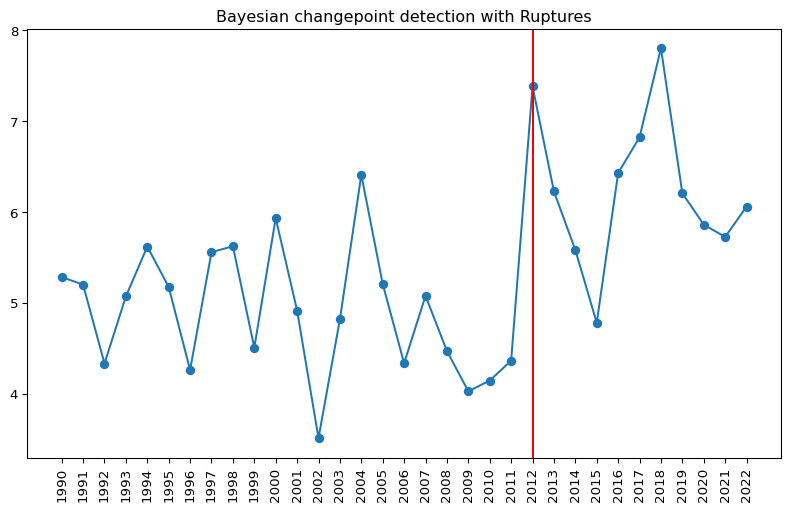

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(800/96, 500/96), dpi=96)

kernel = 'linear'
algo = rpt.KernelCPD(kernel=kernel, min_size=6)
algo.fit(impressions)
result = algo.predict(n_bkps=1)
ax.plot(impressions,marker='o')
for bkp in result[0:-1]:
    ax.axvline(x=bkp, color='r')
ax.set_title("Bayesian changepoint detection with Ruptures")
fig.tight_layout()
#change the x ticks to be the index of mins_played
#crea una lista da 0 a 54
a=list(range(0,33))
b=list(range(1990,2023))
ax.set_xticks(a,b)
#ruota i tick di 90 gradi
plt.xticks(rotation=90)
print("Punti di rottura trovati:", result[0:-1])
plt.show()



## Test Mann-Kendall

### Autocorrelazione

In [16]:
#test durbin watson per determinare autocorrelazione nei residui del modello di regressione lineare
#Il valore della statistica di Durbin-Watson è sempre compreso tra 0 e 4.
#Un valore di 2 indica che non appare presente alcuna autocorrelazione. Valori piccoli di d indicano che i residui successivi sono, in media, vicini in valore l'uno all'altro, o correlati positivamente.
#Valori grandi di d indicano che i residui successivi sono, in media, molto differenti in valore l'uno dall'altro, o correlati negativamente.

# Fit a linear regression model (you can replace this with your specific model)
model_ita = sm.OLS((mins_played['Minuti giocati Italiani'][39:]+mins_played['Minuti giocati Oriundi'][39:]), np.arange(len(mins_played['Minuti giocati Italiani'][39:]))).fit()
model21= sm.OLS(mins_played['Minuti giocati under21'][39:], np.arange(len(mins_played['Minuti giocati under21'][39:]))).fit()
# Calculate Durbin-Watson statistic
durbin_watson_statistic = sm.stats.stattools.durbin_watson(model_ita.resid)
durbin_watson_statistic21 = sm.stats.stattools.durbin_watson(model21.resid)


print(f'Durbin-Watson Statistic: {durbin_watson_statistic}')
print(f'Durbin-Watson Statistic: {durbin_watson_statistic21}')

Durbin-Watson Statistic: 0.5399187279029783
Durbin-Watson Statistic: 0.20914460806255758


In [ ]:
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(12, 8))
sm.graphics.tsa.plot_acf((mins_played['Minuti giocati Italiani'][39:]+mins_played['Minuti giocati Oriundi'][39:]), lags=14, ax=ax)
#print only one plot
plt.show()

In [ ]:
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(12, 8))
sm.graphics.tsa.plot_acf(mins_played["Minuti giocati under21"][39:], lags=14, ax=ax)
plt.show()

### Test Mann-Kendall under-21 2011/2012 to 2022/2023

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.035414895705223604, z=2.1035823408618612, Tau=0.2967032967032967, s=27.0, var_s=152.76633627019092, slope=0.14360108259629795, intercept=5.024261756319172)


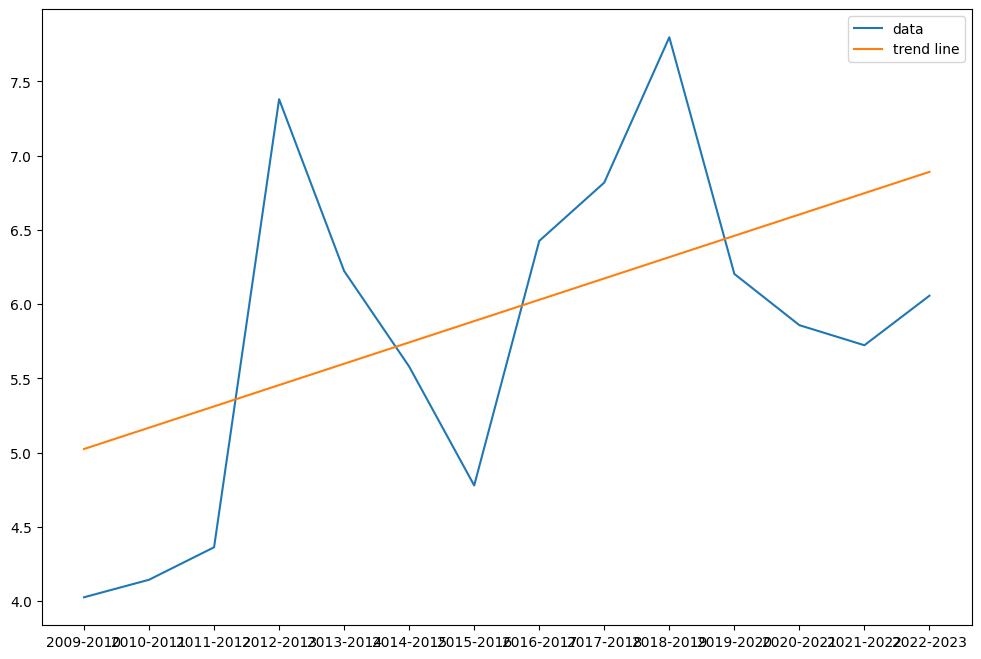

In [31]:
data = (mins_played["Minuti giocati under21"][42:])

fig, ax = plt.subplots(figsize=(12, 8))
res = mk.hamed_rao_modification_test(data,alpha=0.05)
print(res)
trend_line = np.arange(len(data)) * res.slope + res.intercept

ax.plot(data)
ax.plot(data.index, trend_line)
ax.legend(['data', 'trend line'])

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.1005181732074647, z=1.6423467043540767, Tau=0.34065934065934067, s=31.0, var_s=333.6666666666667, slope=0.08801169590643268, intercept=1.9058612440191394)


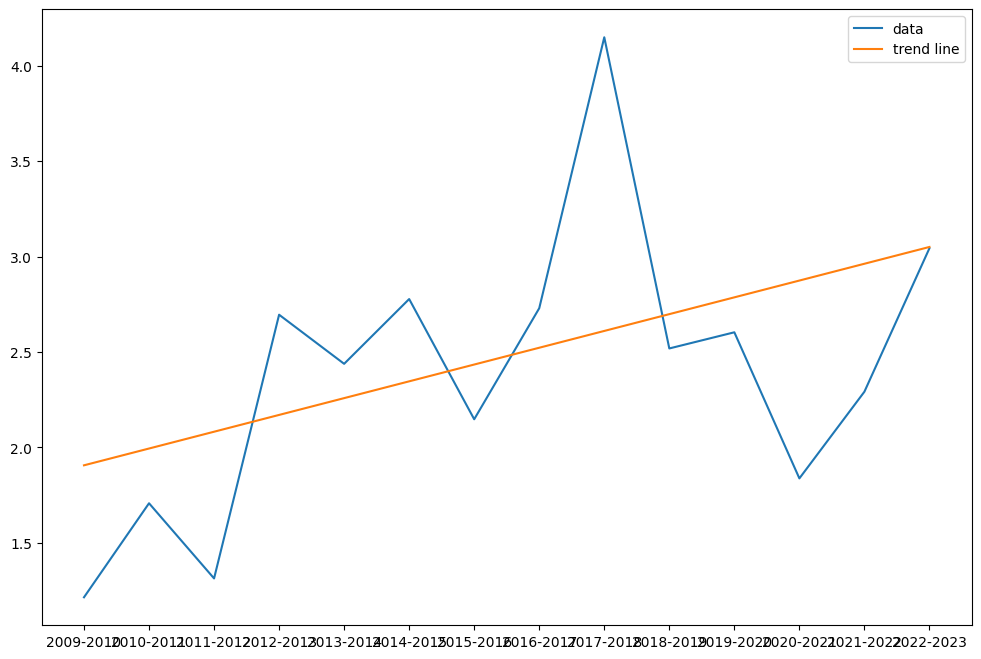

In [40]:
data = (mins_played["Minuti giocati Italiani"][42:] + mins_played["Minuti giocati Oriundi"][42:])

fig, ax = plt.subplots(figsize=(12, 8))
res = mk.hamed_rao_modification_test(data,alpha=0.05)
print(res)
trend_line = np.arange(len(data)) * res.slope + res.intercept

ax.plot(data)
ax.plot(data.index, trend_line)
ax.legend(['data', 'trend line'])

### Test Mann-Kendall under-21 1973/1974 to 1984/1985

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0285390635703624, z=2.1897956058054358, Tau=0.45054945054945056, s=41.0, var_s=333.6666666666667, slope=0.2345959595959597, intercept=5.5077861952861955)


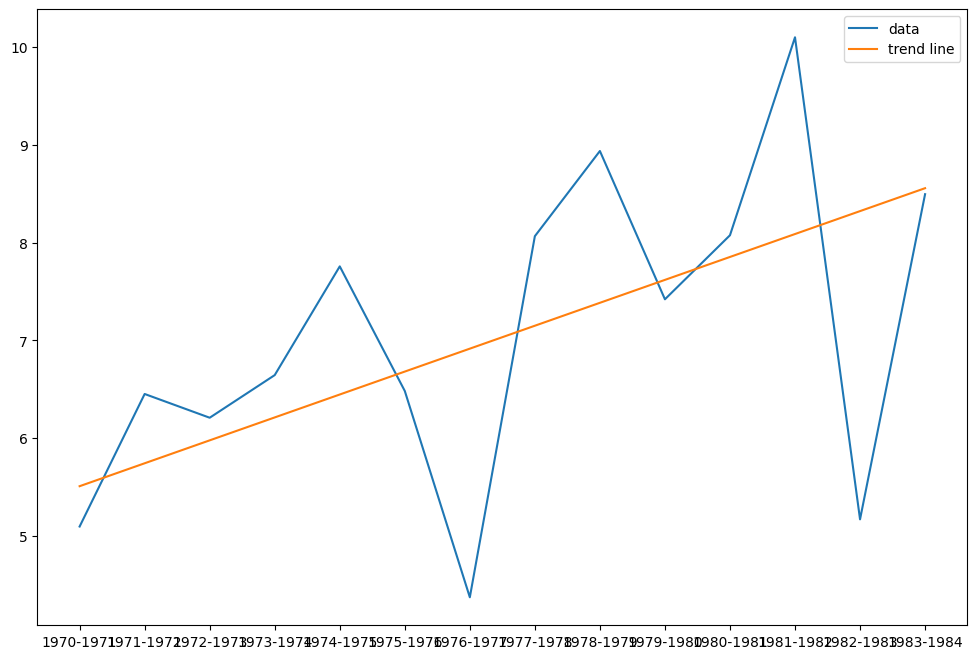

In [24]:
data = (mins_played["Minuti giocati under21"][3:17])

fig, ax = plt.subplots(figsize=(12, 8))
res = mk.hamed_rao_modification_test(data)
print(res)
trend_line = np.arange(len(data)) * res.slope + res.intercept

ax.plot(data)
ax.plot(data.index, trend_line)
ax.legend(['data', 'trend line'])

### Test Mann-Kendall under-21 1985/1986 to 1992/1993

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='decreasing', h=True, p=6.678657626935092e-12, z=-6.8643692512416115, Tau=-0.5, s=-18.0, var_s=6.133333333333332, slope=-0.1591841618802402, intercept=5.918376576219714)


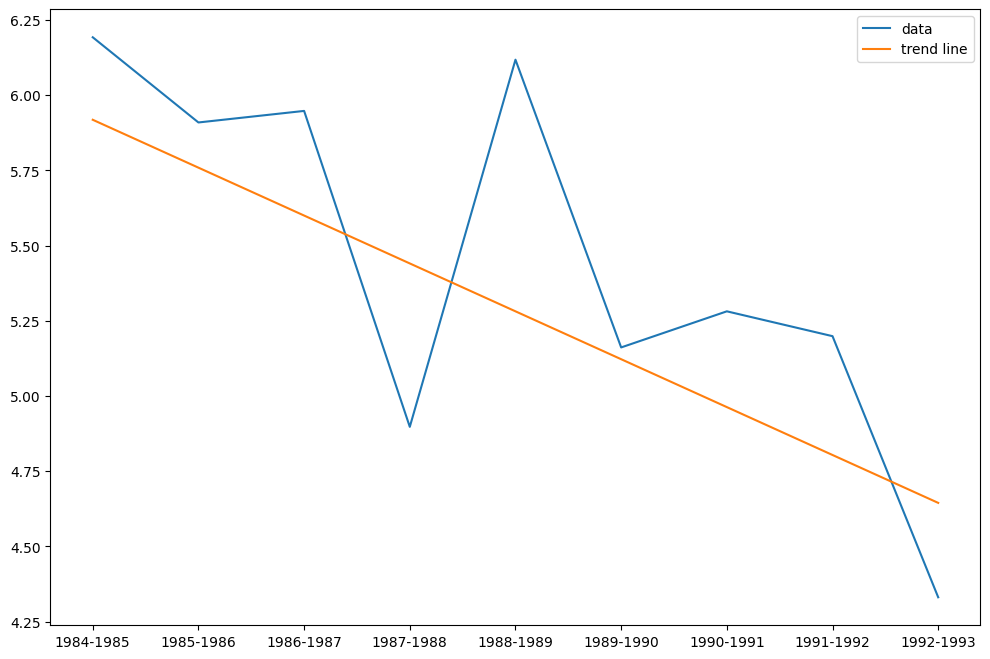

In [26]:
data = (mins_played["Minuti giocati under21"][17:26])

fig, ax = plt.subplots(figsize=(12, 8))
res = mk.hamed_rao_modification_test(data)
print(res)
trend_line = np.arange(len(data)) * res.slope + res.intercept

ax.plot(data)
ax.plot(data.index, trend_line)
ax.legend(['data', 'trend line'])

### Test Mann-kendall e stazioniarietà ADCF 1992/1993 to 2011/2012

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0006624132333039601, z=3.4046812552279486, Tau=0.38235294117647056, s=52.0, var_s=224.38169934640516, slope=0.13155901116427432, intercept=4.670813397129187)


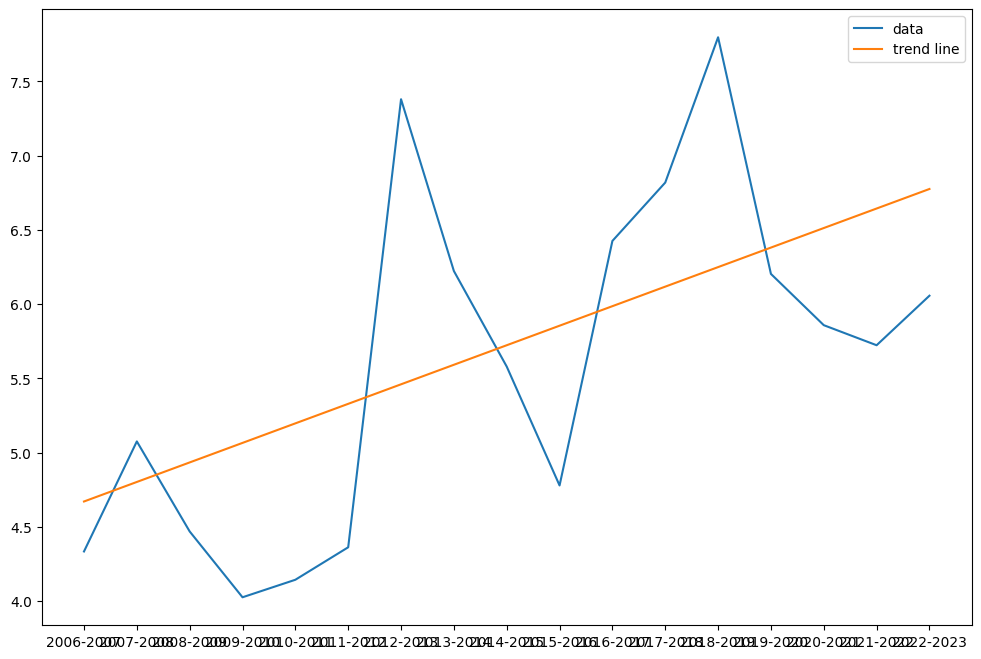

In [44]:
data = (mins_played["Minuti giocati under21"][39:60])

fig, ax = plt.subplots(figsize=(12, 8))
res = mk.hamed_rao_modification_test(data)
print(res)
trend_line = np.arange(len(data)) * res.slope + res.intercept

ax.plot(data)
ax.plot(data.index, trend_line)
ax.legend(['data', 'trend line'])

In [27]:
#Applying ADCF test

from statsmodels.tsa.stattools import adfuller
# Crea due campioni di dati
# Esegui il test di Dickey-Fuller
result = adfuller(mins_played["Minuti giocati under21"][21:46])
print('Statistiche ADF: %f' % result[0])
print('Valore p: %f' % result[1])
print('Valori critici:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))



Statistiche ADF: -4.512388
Valore p: 0.000187
Valori critici:
	1%: -3.753
	5%: -2.998
	10%: -2.639


## Correlazione tra minuti stranieri e minuti italiani

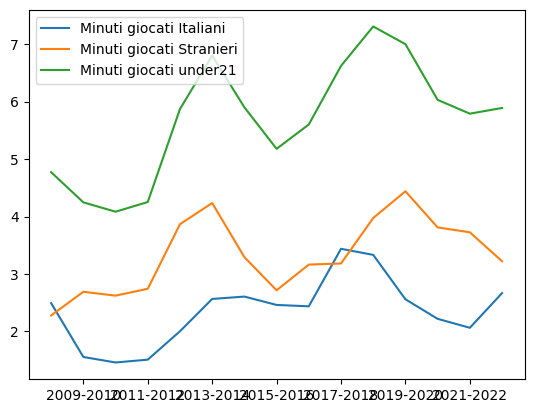

In [45]:
#fai la media di ogni tre anni per i minuti giocati da giocatori italiani e per i giocatori stranieri, poi creaci due lineplot


(mins_played["Minuti giocati Italiani"][40:]+mins_played["Minuti giocati Oriundi"][40:]).rolling(2).mean().plot(label='Minuti giocati Italiani')

(mins_played["Minuti giocati Stranieri"][40:]).rolling(2).mean().plot()
(mins_played["Minuti giocati under21"][40:]).rolling(2).mean().plot()
plt.legend()



In [57]:
#crea un datframe chiamato perc_under_ita_stra
perc_under_ita_stra=mins_played[38:]
perc_under_ita_stra.head()
perc_under_ita_stra["Minuti giocati Stranieri"]=perc_under_ita_stra["Minuti giocati Stranieri"]/perc_under_ita_stra["Minuti giocati under21"]*100
perc_under_ita_stra["Minuti giocati Italiani"]=perc_under_ita_stra["Minuti giocati Italiani"]/perc_under_ita_stra["Minuti giocati under21"]*100+perc_under_ita_stra["Minuti giocati Oriundi"]/perc_under_ita_stra["Minuti giocati under21"]*100
perc_under_ita_stra["Minuti giocati Oriundi"]=perc_under_ita_stra["Minuti giocati Oriundi"]/perc_under_ita_stra["Minuti giocati under21"]*100
perc_under_ita_stra


,Minuti giocati under21,Minuti giocati Italiani,Minuti giocati Stranieri,Minuti giocati Oriundi
2005-2006,5.206007,64.562165,35.437835,8.072504
2006-2007,4.334264,59.630186,40.369814,6.231026
2007-2008,5.075492,60.856814,39.143186,10.317377
2008-2009,4.469032,42.477323,57.522677,15.428996
2009-2010,4.025651,30.166067,69.833933,5.530060
2010-2011,4.143674,41.197036,58.802964,2.752029
2011-2012,4.362440,30.100844,69.899156,2.580508
2012-2013,7.380383,36.515397,63.484603,8.606159
2013-2014,6.223285,39.170084,60.829916,1.625235
2014-2015,5.579612,49.772516,50.227484,6.562493


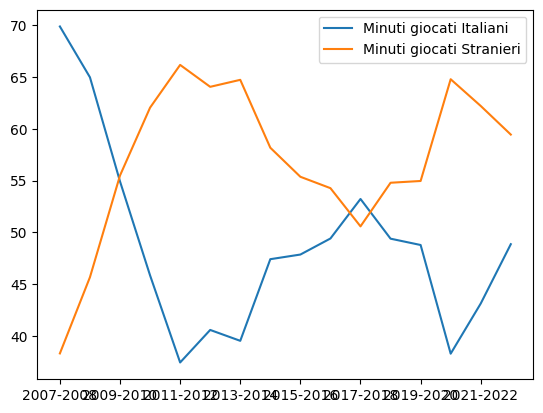

In [63]:
(perc_under_ita_stra["Minuti giocati Italiani"]+perc_under_ita_stra["Minuti giocati Oriundi"]).rolling(3).mean().plot(label='Minuti giocati Italiani')

(perc_under_ita_stra["Minuti giocati Stranieri"]).rolling(3).mean().plot()
#(perc_under_ita_stra["Minuti giocati under21"][40:]).rolling(2).mean().plot()
plt.legend()

In [319]:
#fai la media, variabilità e deviazione standard del periodo 2003-2004/2019-2020 per i minuti giocati da giocatori italiani e per i giocatori stranieri

print((mins_played["Minuti giocati Italiani"][40:] + mins_played["Minuti giocati Oriundi"][40:]).mean())
print((mins_played["Minuti giocati Italiani"][40:] + mins_played["Minuti giocati Oriundi"][40:]).std())
print((mins_played["Minuti giocati Italiani"][40:] + mins_played["Minuti giocati Oriundi"][40:]).var())

print(mins_played["Minuti giocati Stranieri"][40:].mean())
print(mins_played["Minuti giocati Stranieri"][40:].std())
print(mins_played["Minuti giocati Stranieri"][40:].var())

print((mins_played["Minuti giocati Italiani"][40:] + mins_played["Minuti giocati Oriundi"][40:]).describe())
print(mins_played["Minuti giocati Stranieri"][40:].describe())


2.403101741095162
0.7326343808122779
0.5367531359481899
3.279596956406167
0.8690345557522454
0.7552210590915026
count    16.000000
mean      2.403102
std       0.732634
min       1.214381
25%       1.883074
50%       2.477937
75%       2.741029
max       4.148724
dtype: float64
count    16.000000
mean      3.279597
std       0.869035
min       1.986709
25%       2.660619
50%       3.031433
75%       3.719032
max       5.279373
Name: Minuti giocati Stranieri, dtype: float64


In [46]:
#correlazione tra il la percentuale di minuti giocati dagli under 21 stranieri e italiani nel periodo 2011-2012 e 2021-2022
from scipy.stats import pearsonr,spearmanr, kendalltau

corr_pearson, p_value = pearsonr(mins_played["Minuti giocati Italiani"][40:] + mins_played["Minuti giocati Oriundi"][40:],mins_played["Minuti giocati under21"][40:])
correlazione_spearman, p_value_spearman= spearmanr(mins_played["Minuti giocati Italiani"][40:] + mins_played["Minuti giocati Oriundi"][40:],mins_played["Minuti giocati under21"][40:])
correlazione_kendall, p_value_kendall = kendalltau(mins_played["Minuti giocati Italiani"][40:] + mins_played["Minuti giocati Oriundi"][40:],mins_played["Minuti giocati under21"][40:])
print(f"Correlazione di Pearson: {corr_pearson}")
print(f"P-value Pearson: {p_value}")
print(f"Correlazione di Spearman: {correlazione_spearman}")
print(f"P-value Spearman: {p_value_spearman}")
print(f"Correlazione di Kendall: {correlazione_kendall}")
print(f"P-value Kendall: {p_value_kendall}")


Correlazione di Pearson: 0.6464639703584583
P-value Pearson: 0.006809663357140005
Correlazione di Spearman: 0.6323529411764706
P-value Spearman: 0.008577584103099355
Correlazione di Kendall: 0.4666666666666666
P-value Kendall: 0.011480597067017682


In [10]:
mins_played["Minuti giocati under21"][18:45]

1985-1986    5.909428
1986-1987    5.947811
1987-1988    4.897643
1988-1989    6.118093
1989-1990    5.161616
1990-1991    5.281640
1991-1992    5.199049
1992-1993    4.331105
1993-1994    5.068627
1994-1995    5.617350
1995-1996    5.172906
1996-1997    4.260992
1997-1998    5.555110
1998-1999    5.621064
1999-2000    4.505348
2000-2001    5.929293
2001-2002    4.913844
2002-2003    3.509804
2003-2004    4.816993
2004-2005    6.406433
2005-2006    5.206007
2006-2007    4.334264
2007-2008    5.075492
2008-2009    4.469032
2009-2010    4.025651
2010-2011    4.143674
2011-2012    4.362440
Name: Minuti giocati under21, dtype: float64

In [168]:
mean_value = np.mean(mins_played["Minuti giocati under21"][18:45])
print(f"Media: {mean_value}")

# Calcola la varianza
variance_value = np.var(mins_played["Minuti giocati under21"][18:45])
print(f"Varianza: {variance_value}")

# Calcola l'intervallo di confidenza al 95%
confidence_interval = stats.t.interval(0.95, len(mins_played["Minuti giocati under21"][18:45])-1, loc=mean_value, scale=stats.sem(mins_played["Minuti giocati under21"][18:45]))
confidence_interval_90 = stats.t.interval(0.90, len(mins_played["Minuti giocati under21"][18:45])-1, loc=mean_value, scale=stats.sem(mins_played["Minuti giocati under21"][18:45]))

print(f"Intervallo di Confidenza al 95%: {confidence_interval}")
print(f"Intervallo di Confidenza al 90%: {confidence_interval_90}")

Media: 5.031137387713468
Varianza: 0.49697645940292995
Intervallo di Confidenza al 95%: (4.746949911064713, 5.315324864362222)
Intervallo di Confidenza al 90%: (4.795326971364816, 5.266947804062119)


In [169]:
mins_played["Minuti giocati under21"][45:]

2012-2013    7.380383
2013-2014    6.223285
2014-2015    5.579612
2015-2016    4.778841
2016-2017    6.425837
2017-2018    6.818979
2018-2019    7.797581
2019-2020    6.203748
2020-2021    5.858453
2021-2022    5.723285
2022-2023    6.056885
Name: Minuti giocati under21, dtype: float64

In [170]:
mean_value = np.mean(mins_played["Minuti giocati under21"][45:])
print(f"Media: {mean_value}")

# Calcola la varianza
variance_value = np.var(mins_played["Minuti giocati under21"][45:])
print(f"Varianza: {variance_value}")

# Calcola l'intervallo di confidenza al 95%
confidence_interval = stats.t.interval(0.95, len(mins_played["Minuti giocati under21"][45:])-1, loc=mean_value, scale=stats.sem(mins_played["Minuti giocati under21"][45:]))
confidence_interval_90 = stats.t.interval(0.90, len(mins_played["Minuti giocati under21"][45:])-1, loc=mean_value, scale=stats.sem(mins_played["Minuti giocati under21"][45:]))

print(f"Intervallo di Confidenza al 95%: {confidence_interval}")
print(f"Intervallo di Confidenza al 90%: {confidence_interval_90}")

Media: 6.258808177468464
Varianza: 0.6464716130103549
Intervallo di Confidenza al 95%: (5.692285914566664, 6.825330440370264)
Intervallo di Confidenza al 90%: (5.797975327751416, 6.719641027185512)


In [173]:
mean_value = np.mean(mins_played["Minuti giocati under21"][8:18])
print(f"Media: {mean_value}")

# Calcola la varianza
variance_value = np.var(mins_played["Minuti giocati under21"][8:18])
print(f"Varianza: {variance_value}")

confidence_interval_99 = stats.t.interval(0.99, len(mins_played["Minuti giocati under21"][8:18])-1, loc=mean_value, scale=stats.sem(mins_played["Minuti giocati under21"][8:18]))
confidence_interval_amplitude_99 = confidence_interval_99[1] - confidence_interval_99[0]
print(f"Ampiezza dell'Intervallo al 99%: {confidence_interval_amplitude_99}")
# Calcola l'intervallo di confidenza al 95%
confidence_interval_95 = stats.t.interval(0.95, len(mins_played["Minuti giocati under21"][8:18])-1, loc=mean_value, scale=stats.sem(mins_played["Minuti giocati under21"][8:18]))
confidence_interval_amplitude_95 = confidence_interval_95[1] - confidence_interval_95[0]
print(f"Ampiezza dell'Intervallo al 95%: {confidence_interval_amplitude_95}")
confidence_interval_90 = stats.t.interval(0.90, len(mins_played["Minuti giocati under21"][8:18])-1, loc=mean_value, scale=stats.sem(mins_played["Minuti giocati under21"][8:18]))
confidence_interval_amplitude_90 = confidence_interval_90[1] - confidence_interval_90[0]
print(f"Ampiezza dell'Intervallo al 90%: {confidence_interval_amplitude_90}")

print(f"Intervallo di Confidenza al 99%: {confidence_interval_99}")
print(f"Intervallo di Confidenza al 95%: {confidence_interval_95}")
print(f"Intervallo di Confidenza al 90%: {confidence_interval_90}")

Media: 7.495185185185186
Varianza: 2.349456796925484
Ampiezza dell'Intervallo al 99%: 3.320885156204092
Ampiezza dell'Intervallo al 95%: 2.3116136312132705
Ampiezza dell'Intervallo al 90%: 1.8731894107397373
Intervallo di Confidenza al 99%: (5.83474260708314, 9.155627763287232)
Intervallo di Confidenza al 95%: (6.33937836957855, 8.65099200079182)
Intervallo di Confidenza al 90%: (6.558590479815317, 8.431779890555054)


In [ ]:
mins_played["Minuti giocati under21"][10:18]

## Test Statistici

In [144]:
 # applica il test Mann-Whitney ai dati dal 2000 al 2011 e dal 2012 al 2022
from scipy.stats import wilcoxon
# Crea due campioni di dati


# Esegui il test di Mann-Whitney
stat, p = wilcoxon(mins_played["Minuti giocati under21"][31:42],mins_played["Minuti giocati under21"][43:])
print('stat=%.3f, p=%.3f' % (stat, p))



stat=2.000, p=0.003


In [161]:
#Test di Mann-Kendall per Tendenze
from scipy.stats import mstats
# Crea due campioni di dati
# Esegui il test di Mann-Kendall
stat, p = mstats.kendalltau(mins_played["Minuti giocati under21"][31:42],mins_played["Minuti giocati under21"][43:])
print('stat=%.3f, p=%.3f' % (stat, p))


stat=0.455, p=0.060


In [53]:
#fai il test t student per vedere se la variazione dei minuti giocati è significativa prima del 2012 e dopo il 2012
# Path: under21.ipynb
from scipy.stats import ttest_ind


# Esegui il test t
ttest_ind(mins_played["Minuti giocati under21"][31:42],mins_played["Minuti giocati under21"][43:])



Ttest_indResult(statistic=-4.046468831328841, pvalue=0.0006310842777070342)

In [33]:
# Esegui l'ANOVA
f_statistic, p_value = stats.f_oneway(mins_played["Minuti giocati under21"][31:42],mins_played["Minuti giocati under21"][43:])

# Stampa i risultati
print("Statistiche ANOVA:")
print("F-statistic:", f_statistic)
print("P-value:", p_value)
# Confronta il p-value con il livello di significatività (solitamente 0.05)
alpha = 0.05
if p_value < alpha:
    print("Il p-value è inferiore a", alpha, " - ci sono variazioni statisticamente significative.")
else:
    print("Il p-value è maggiore di", alpha, " - non ci sono variazioni statisticamente significative.")

Statistiche ANOVA:
F-statistic: 11.57748809866386
P-value: 0.002681823460552317
Il p-value è inferiore a 0.05  - ci sono variazioni statisticamente significative.


In [23]:
# Specifica la distribuzione teorica o la distribuzione di riferimento
# Ad esempio, se stai cercando di confrontare con una distribuzione normale, puoi usare:
# distribuzione_di_riferimento = 'norm'

# Esegui il test Kolmogorov-Smirnov
kstest(mins_played["Minuti giocati under21"][31:42],mins_played["Minuti giocati under21"][42:])

KstestResult(statistic=0.6515151515151515, pvalue=0.00929088410579863, statistic_location=5.206007442849548, statistic_sign=1)

In [49]:
print(mins_played['Minuti giocati under21'][31:43].mean())
print(mins_played['Minuti giocati under21'][43:].mean())

4.7660773107754535
6.258808177468464


In [52]:
print((mins_played['Minuti giocati Italiani'][31:43]+mins_played['Minuti giocati Oriundi'][31:43]).mean())
print((mins_played['Minuti giocati Italiani'][43:]+mins_played['Minuti giocati Oriundi'][43:]).mean())

2.5754845930929524
2.6570852061282686


In [78]:
#esegue la media dei minuti giocati normalizzati ogni 8 stagioni
mins_played_10=pd.DataFrame(columns=["Minuti giocati normalizzati TM"])
mins_played_10.loc["1969-1976","Minuti giocati normalizzati TM"]=mins_played["Minuti giocati normalizzati TM"][0:8].mean()
mins_played_10.loc["1977-1984","Minuti giocati normalizzati TM"]=mins_played["Minuti giocati normalizzati TM"][8:16].mean()
mins_played_10.loc["1985-1992","Minuti giocati normalizzati TM"]=mins_played["Minuti giocati normalizzati TM"][16:24].mean()
mins_played_10.loc["1993-2000","Minuti giocati normalizzati TM"]=mins_played["Minuti giocati normalizzati TM"][24:32].mean()
mins_played_10.loc["2001-2008","Minuti giocati normalizzati TM"]=mins_played["Minuti giocati normalizzati TM"][32:40].mean()
mins_played_10.loc["2009-2017","Minuti giocati normalizzati TM"]=mins_played["Minuti giocati normalizzati TM"][40:48].mean()
mins_played_10.loc["2017-2022","Minuti giocati normalizzati TM"]=mins_played["Minuti giocati normalizzati TM"][48:].mean()

mins_played_10.loc["1969-1976","Minuti giocati normalizzati FIX"]=mins_played["Minuti giocati normalizzati FIX"][0:8].mean()
mins_played_10.loc["1977-1984","Minuti giocati normalizzati FIX"]=mins_played["Minuti giocati normalizzati FIX"][8:16].mean()
mins_played_10.loc["1985-1992","Minuti giocati normalizzati FIX"]=mins_played["Minuti giocati normalizzati FIX"][16:24].mean()
mins_played_10.loc["1993-2000","Minuti giocati normalizzati FIX"]=mins_played["Minuti giocati normalizzati FIX"][24:32].mean()
mins_played_10.loc["2001-2008","Minuti giocati normalizzati FIX"]=mins_played["Minuti giocati normalizzati FIX"][32:40].mean()
mins_played_10.loc["2009-2017","Minuti giocati normalizzati FIX"]=mins_played["Minuti giocati normalizzati FIX"][40:48].mean()
mins_played_10.loc["2017-2022","Minuti giocati normalizzati FIX"]=mins_played["Minuti giocati normalizzati FIX"][48:].mean()


mins_played_10.head(8)

,Minuti giocati normalizzati TM,Minuti giocati normalizzati FIX
1969-1976,6.403704,6.149032
1977-1984,8.055366,7.807534
1985-1992,6.037921,5.355817
1993-2000,5.629846,5.216522
2001-2008,5.319778,4.841484
2009-2017,5.561553,5.365032
2017-2022,6.612219,6.409534


## Grafici

Text(0.5, 1.0, 'Minuti giocati dai giocatori Under 21 in Serie A ogni 8 anni')

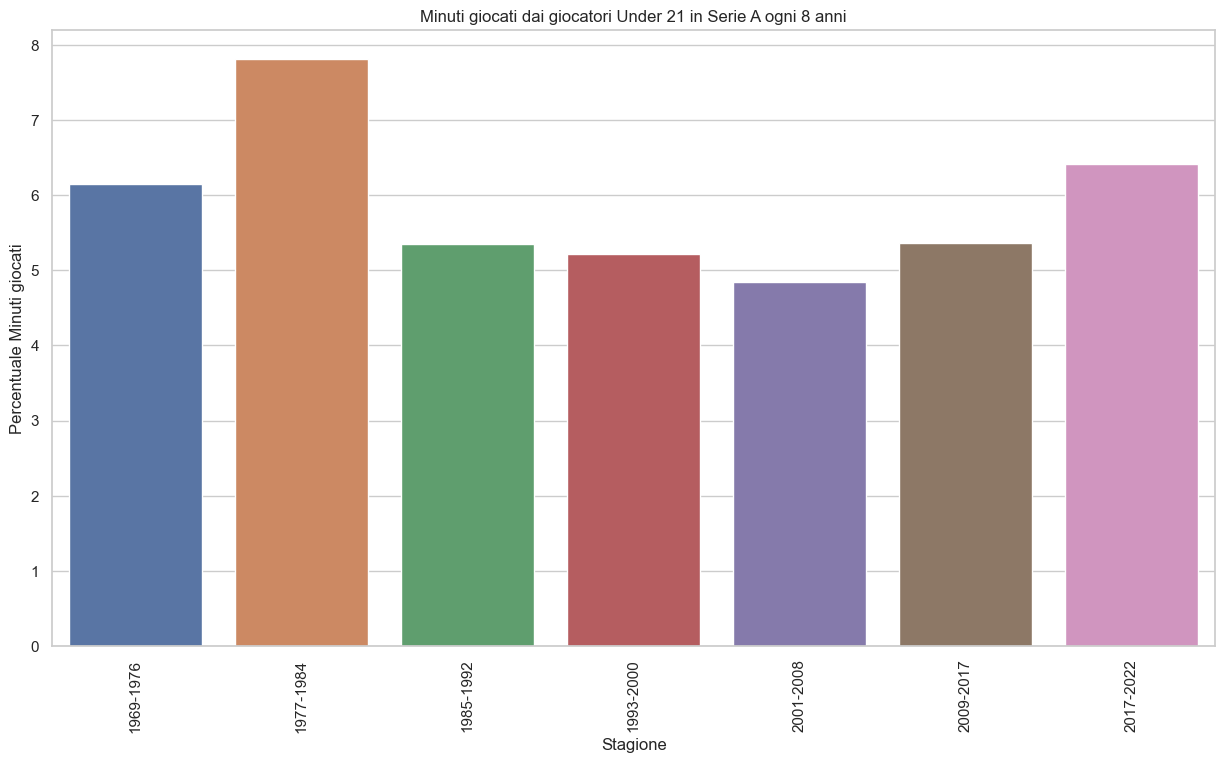

In [10]:
plt.figure(figsize=(15,8))
sns.barplot(x=mins_played_10.index, y=mins_played_10["Minuti giocati normalizzati FIX"])
plt.xticks(rotation=90)
plt.xlabel("Stagione")
plt.ylabel("Percentuale Minuti giocati")
plt.title("Minuti giocati dai giocatori Under 21 in Serie A ogni 8 anni")

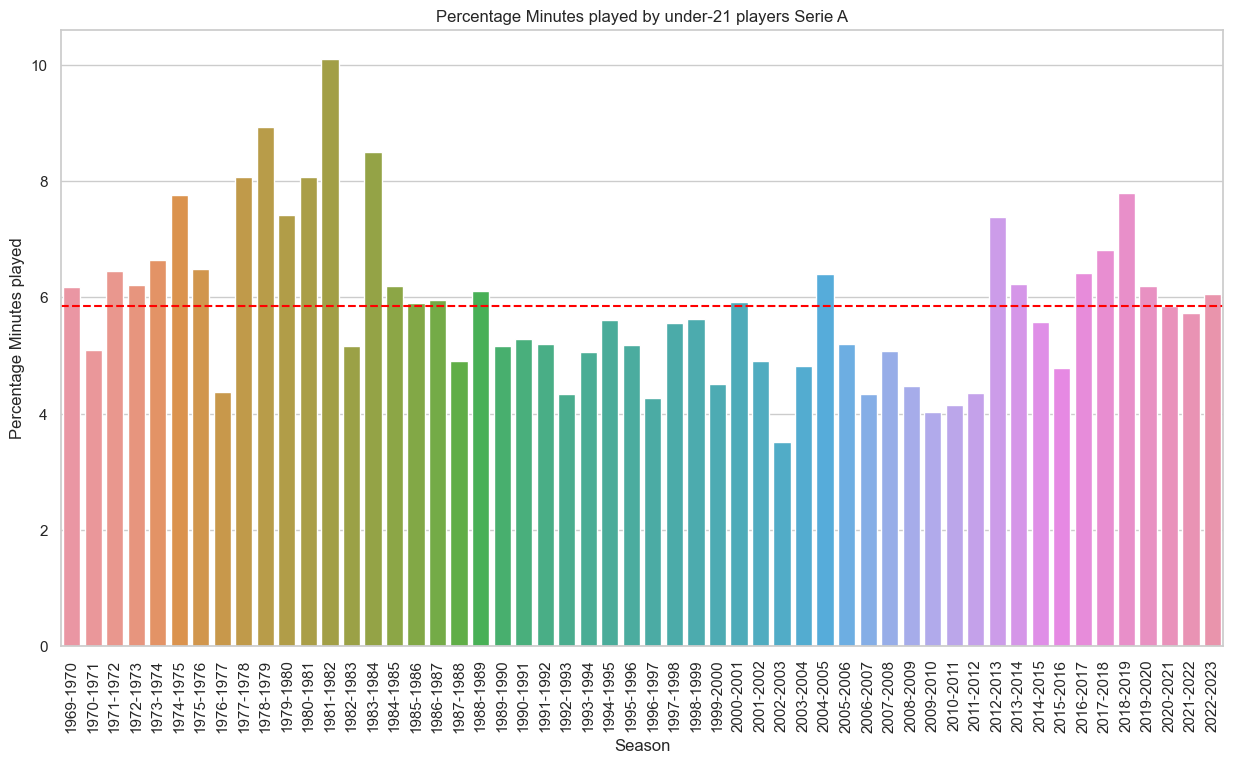

In [46]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,8))
sns.barplot(x=mins_played.index, y=mins_played["Minuti giocati under21"])
plt.xticks(rotation=90)
plt.xlabel("Season")
plt.ylabel("Percentage Minutes played")
plt.title("Percentage Minutes played by under-21 players Serie A")
#print line mean
plt.axhline(mins_played["Minuti giocati under21"].mean(), color='red', linestyle='--')






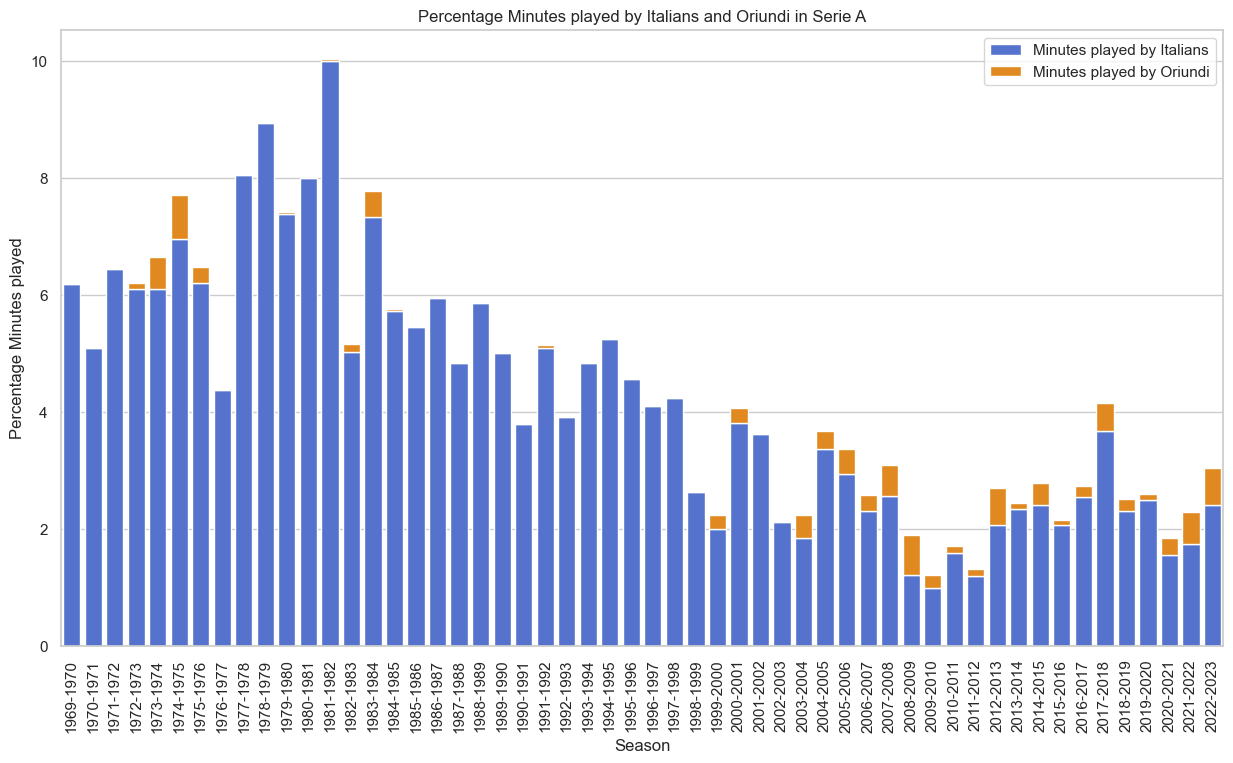

In [48]:
# Supponiamo che tu abbia un DataFrame chiamato 'mins_played' con le colonne "Minuti giocati normalizzati Italiani" e "Minuti giocati normalizzati Stranieri"

plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
# Crea l'istogramma utilizzando Seaborn
sns.barplot(data=mins_played, x=mins_played.index, y="Minuti giocati Italiani", color="royalblue",label="Minutes played by Italians")
sns.barplot(data=mins_played, x=mins_played.index, y="Minuti giocati Oriundi",color="darkorange",label="Minutes played by Oriundi", bottom=mins_played["Minuti giocati Italiani"])

# Aggiungi etichette e titoli
plt.xticks(rotation=90)
plt.xlabel('Season')
plt.ylabel('Percentage Minutes played') 
plt.title('Percentage Minutes played by Italians and Oriundi in Serie A')

# Aggiungi legenda
plt.legend()

# Mostra l'istogramma
plt.show()

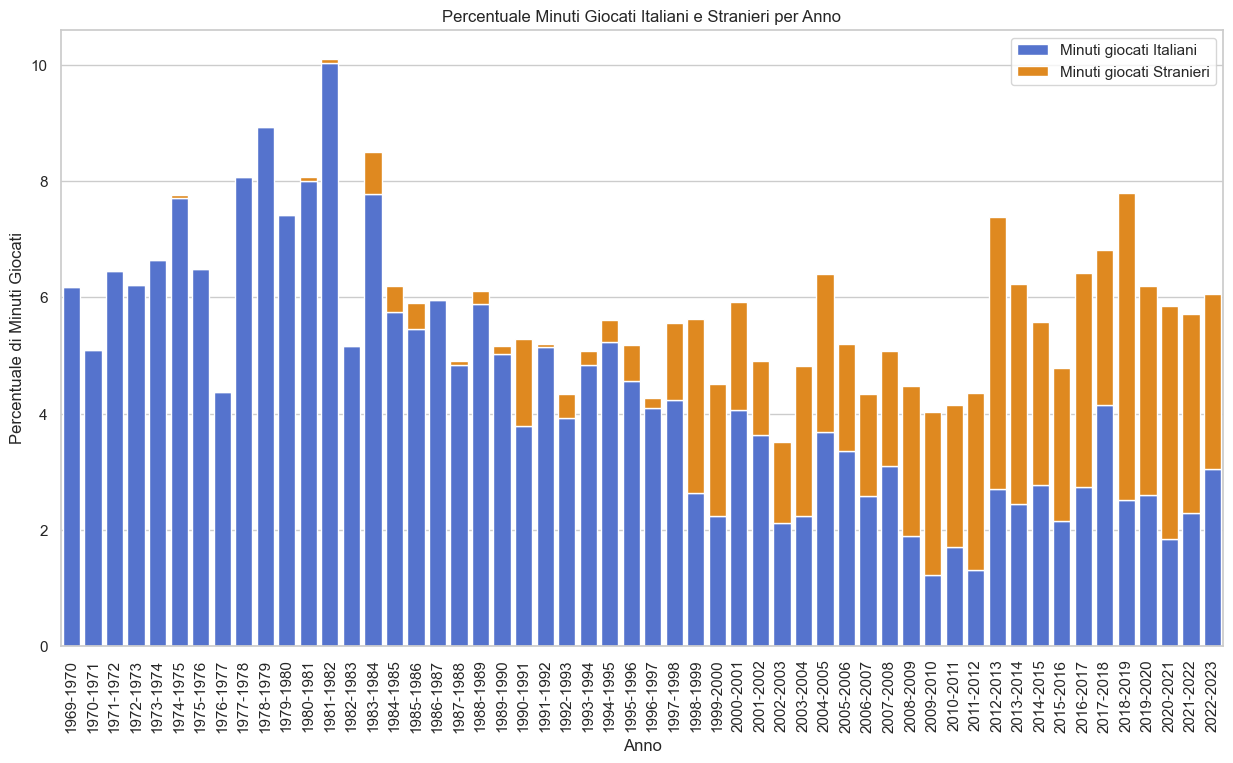

In [ ]:
# Supponiamo che tu abbia un DataFrame chiamato 'mins_played' con le colonne "Minuti giocati normalizzati Italiani" e "Minuti giocati normalizzati Stranieri"

plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
# Crea l'istogramma utilizzando Seaborn
sns.barplot(data=mins_played, x=mins_played.index, y="Minuti giocati normalizzati Italiani", color="royalblue",label="Minuti giocati Italiani")
sns.barplot(data=mins_played, x=mins_played.index, y="Minuti giocati normalizzati Stranieri",color="darkorange",label="Minuti giocati Stranieri", bottom=mins_played["Minuti giocati normalizzati Italiani"])

# Aggiungi etichette e titoli
plt.xticks(rotation=90)
plt.xlabel('Anno')
plt.ylabel('Percentuale di Minuti Giocati')
plt.title('Percentuale Minuti Giocati Italiani e Stranieri per Anno')

# Aggiungi legenda
plt.legend()

# Mostra l'istogramma
plt.show()

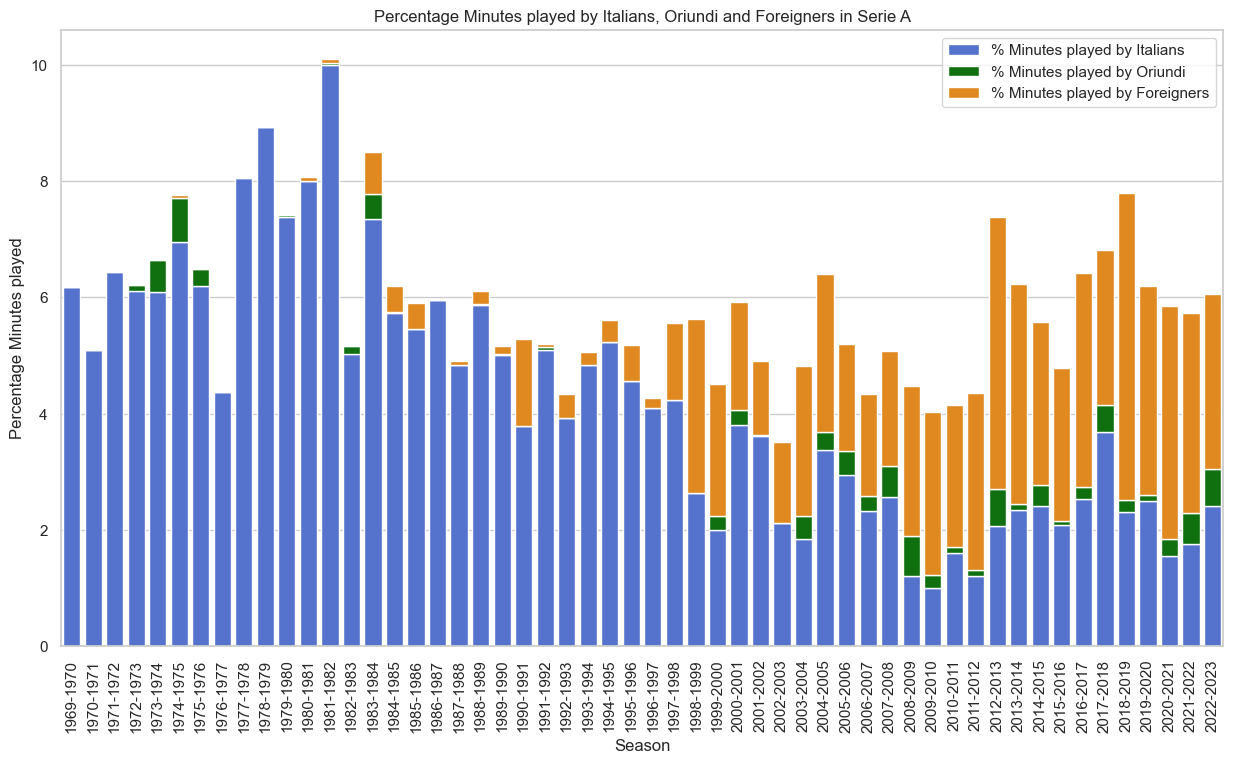

In [49]:
# Supponiamo che tu abbia un DataFrame chiamato 'mins_played' con le colonne "Minuti giocati normalizzati Italiani" e "Minuti giocati normalizzati Stranieri"

plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
# Crea l'istogramma utilizzando Seaborn
sns.barplot(data=mins_played, x=mins_played.index, y="Minuti giocati Italiani", color="royalblue",label="% Minutes played by Italians")
sns.barplot(data=mins_played, x=mins_played.index, y="Minuti giocati Oriundi",color="green",label="% Minutes played by Oriundi", bottom=mins_played["Minuti giocati Italiani"])
sns.barplot(data=mins_played, x=mins_played.index, y="Minuti giocati Stranieri",color="darkorange",label="% Minutes played by Foreigners", bottom=mins_played["Minuti giocati Italiani"] + mins_played["Minuti giocati Oriundi"])



# Aggiungi etichette e titoli
plt.xticks(rotation=90)
plt.xlabel('Season')
plt.ylabel('Percentage Minutes played') 
plt.title('Percentage Minutes played by Italians, Oriundi and Foreigners in Serie A')

# Aggiungi legenda
plt.legend()

# Mostra l'istogramma
plt.show()

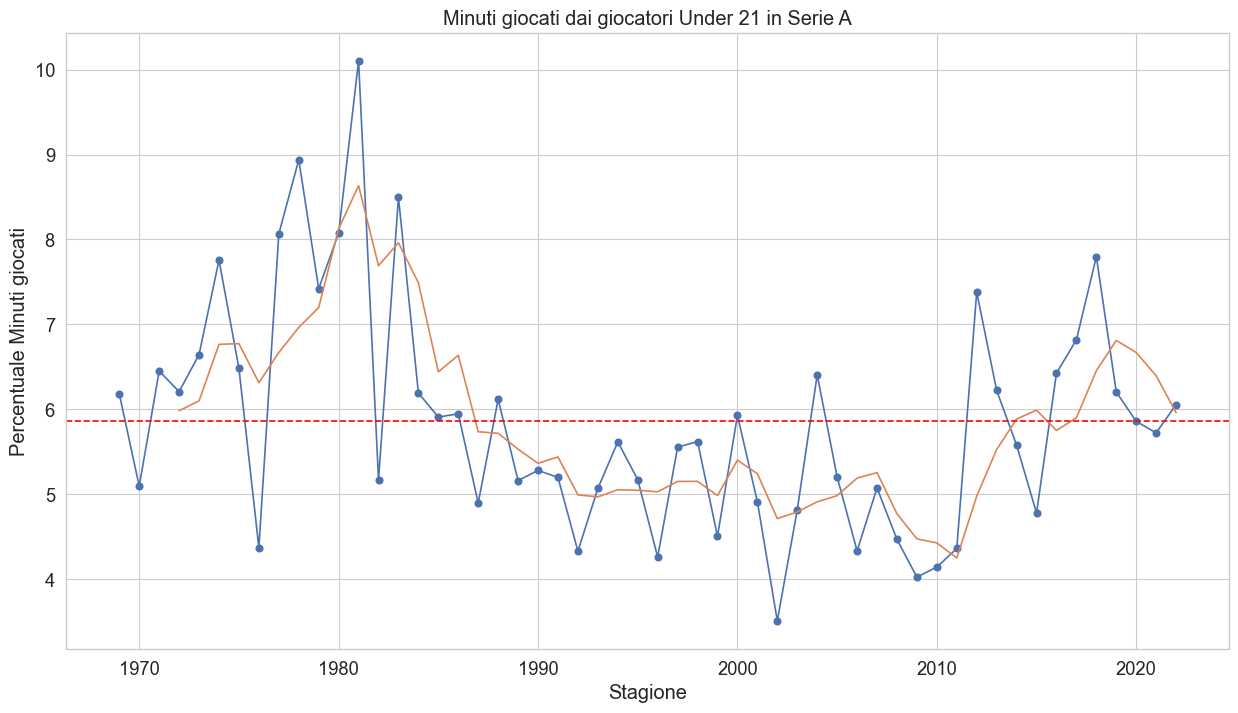

In [166]:
#print a line plot with the minutes played normalized with line mean and marker 
plt.figure(figsize=(15,8))
plt.plot(mins_played.index,mins_played["Minuti giocati under21"],marker='o')
plt.xticks(rotation=90)
plt.xlabel("Stagione")
plt.ylabel("Percentuale Minuti giocati")
plt.title("Minuti giocati dai giocatori Under 21 in Serie A")
#print line mean
mins_played["Minuti giocati under21"].rolling(4).mean().plot()
plt.axhline(mins_played["Minuti giocati under21"].mean(), color='red', linestyle='--')


KeyError: 'Uefa_Ranking'

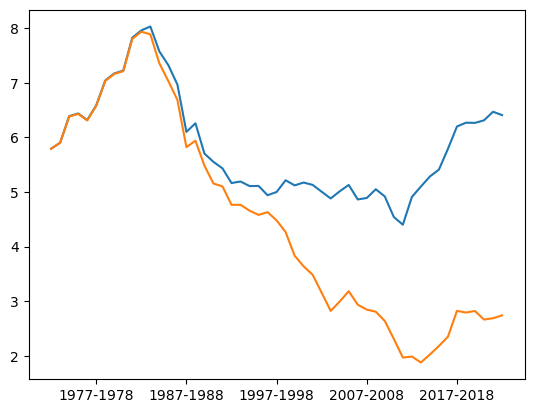

In [337]:

mins_played["Minuti giocati under21"].rolling(6).mean().plot()
(mins_played["Minuti giocati Italiani"]+mins_played["Minuti giocati Oriundi"]).rolling(6).mean().plot(label='Minuti giocati Italiani')
mins_played["Uefa_Ranking"].rolling(6).mean().plot()

plt.legend()